# Model sa sintetički generiranim podacima

## Početno postavljanje

In [ ]:
import numpy as np
import os
import shutil
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Default title text
!unzip cats_vs_dogs_baseline_dataset.zip
!unzip synthetic_cat_samples.zip

In [ ]:
# Funkcija za kombiniranje trening setova
def copy_synthetic_images(synthetic_folder, target_folder, num_images):
    synthetic_images = os.listdir(synthetic_folder)[:num_images]
    for image in synthetic_images:
        src_path = os.path.join(synthetic_folder, image)
        dst_path = os.path.join(target_folder, image)
        shutil.copy(src_path, dst_path)

In [ ]:
# Funkcija za prikaz metrika povijesti treniranja
def plot_all_metrics(history):
    epochs = range(1, len(history['accuracy']) + 1)

    metrics_to_plot = ['accuracy', 'precision', 'recall', 'auc', 'loss']
    metric_titles = {
        'accuracy': 'Točnost',
        'precision': 'Preciznost',
        'recall': 'Osjetljivost',
        'auc': 'AUC',
        'loss': 'Gubitak'
    }

    for metric in metrics_to_plot:
        plt.figure(figsize=(12, 6))

        # Graf trening metrika
        plt.plot(epochs, history[metric], 'bo', label=f'Trening {metric_titles[metric]}')

        # Graf validacijskih metrika
        val_metric = f'val_{metric}'
        plt.plot(epochs, history[val_metric], 'b', label=f'Validacija {metric_titles[metric]}')

        plt.title(f'Trening i validacija - {metric_titles[metric]}')
        plt.xlabel('Epoha')
        plt.ylabel(metric_titles[metric])
        plt.legend()

        plt.show()

## Definiranje arhitekture modela

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Konvolucijska baza
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
# Gusti slojevi
x = layers.Dense(512, activation="relu")(x)

# Završni sloj za  binarnu klasifikaciju
outputs = layers.Dense(1, activation="sigmoid")(x)

# Kreiranje modela
model = keras.Model(inputs=inputs, outputs=outputs)

## Kompajliranje modela

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

validation_dataset = image_dataset_from_directory(
    '/content/drive/MyDrive/cats_vs_dogs_baseline_subset/validation',
    label_mode='binary',
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    '/content/drive/MyDrive/cats_vs_dogs_baseline_subset/test',
    label_mode='binary',
    image_size=(180, 180),
    batch_size=32,
    shuffle=False
)

Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


## Treniranje modela

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="/content/drive/MyDrive/synthetic_data_model.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

synthetic_folder = '/content/synthetic_cat_samples'
original_cat_folder = '/content/cats_vs_dogs_baseline_dataset/train/cat'

all_histories = {}
best_metrics = {}
lowest_val_loss = float('inf')
best_model_key = None
best_model_weights = None

# Trening petlja
for num_synthetic_images in [300, 600, 900]:
    # Kopiranje sintetičkih fotografija
    copy_synthetic_images(synthetic_folder, original_cat_folder, num_synthetic_images)

    # Novi IDG za kopirani trening set
    train_gen = ImageDataGenerator().flow_from_directory(
        '/content/cats_vs_dogs_baseline_dataset/train',
        target_size=(180, 180),
        batch_size=32,
        class_mode='binary'
    )

    # Treniranje modela
    history = model.fit(
        train_gen,
        epochs=30,
        validation_data=validation_dataset,
        callbacks=callbacks
    )

    # Dohvat metrika modela
    val_loss = history.history['val_loss'][-1]
    val_accuracy = history.history['val_accuracy'][-1]
    val_precision = history.history['val_precision'][-1]
    val_recall = history.history['val_recall'][-1]
    val_auc = history.history['val_auc'][-1]

    # Spremanje metrika
    metrics = {
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_auc': val_auc
    }

    best_metrics[num_synthetic_images] = metrics

    # Odabir najboljeg modela po gubitku
    if val_loss < lowest_val_loss:
        lowest_val_loss = val_loss
        best_model_key = num_synthetic_images
        best_model_weights = model.get_weights()

    # Brisanje kopiranih sintetičkih instanci
    copied_synthetic_images = os.listdir(synthetic_folder)[:num_synthetic_images]
    for image_name in copied_synthetic_images:
        os.remove(os.path.join(original_cat_folder, image_name))

    # Spremanje povijesti treniranja modela
    all_histories[num_synthetic_images] = history.history

# Postavljanje najboljeg modela
model.set_weights(best_model_weights)

print(f"Model s najmanjim gubitkom je treniran nad {best_model_key} sintetičkih instanci.")
print(f"Gubitak: {best_metrics[best_model_key]}")

Found 2300 images belonging to 2 classes.
Epoch 1/30
72/72 [==============================] - 7s 63ms/step - loss: 0.6994 - accuracy: 0.6017 - precision: 0.6098 - recall: 0.9600 - auc: 0.5181 - val_loss: 0.6776 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 1.0000 - val_auc: 0.5935
Epoch 2/30
72/72 [==============================] - 4s 56ms/step - loss: 0.6587 - accuracy: 0.6091 - precision: 0.6103 - recall: 0.9900 - auc: 0.5709 - val_loss: 0.6509 - val_accuracy: 0.6980 - val_precision: 0.7043 - val_recall: 0.9800 - val_auc: 0.6199
Epoch 3/30
72/72 [==============================] - 4s 54ms/step - loss: 0.6359 - accuracy: 0.6448 - precision: 0.6428 - recall: 0.9371 - auc: 0.6564 - val_loss: 0.6124 - val_accuracy: 0.6920 - val_precision: 0.7356 - val_recall: 0.8743 - val_auc: 0.6752
Epoch 4/30
72/72 [==============================] - 4s 54ms/step - loss: 0.5796 - accuracy: 0.6952 - precision: 0.7159 - recall: 0.8279 - auc: 0.7432 - val_loss: 0.5507 - val_accuracy: 0.7310 -

## Rezultati i najbolji model

In [ ]:
# Ručno spremanje najboljeg modela
model.save("/content/drive/MyDrive/best_synthetic_data_model.keras")

Rezultati metrika za model treniran nad 300 sintetičkih instanci:


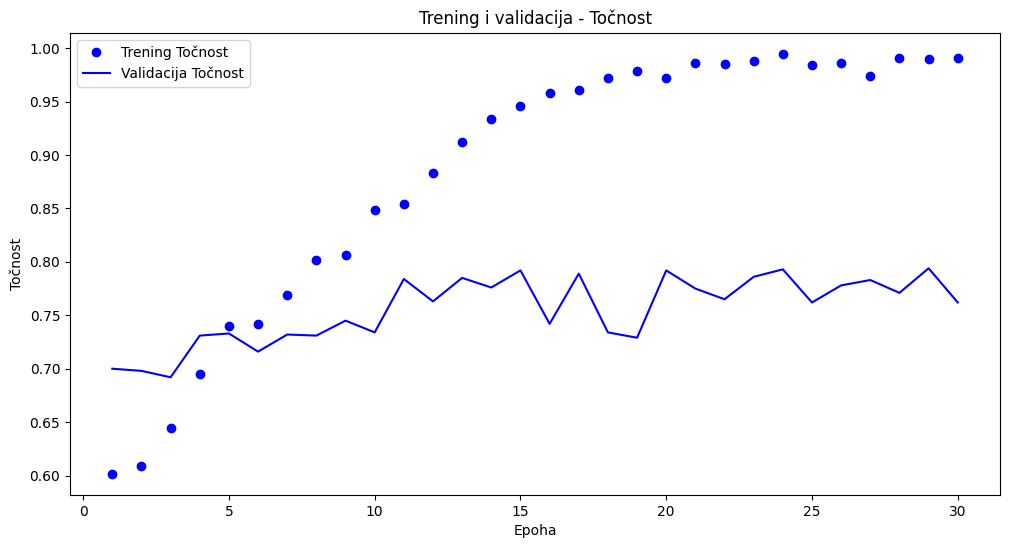

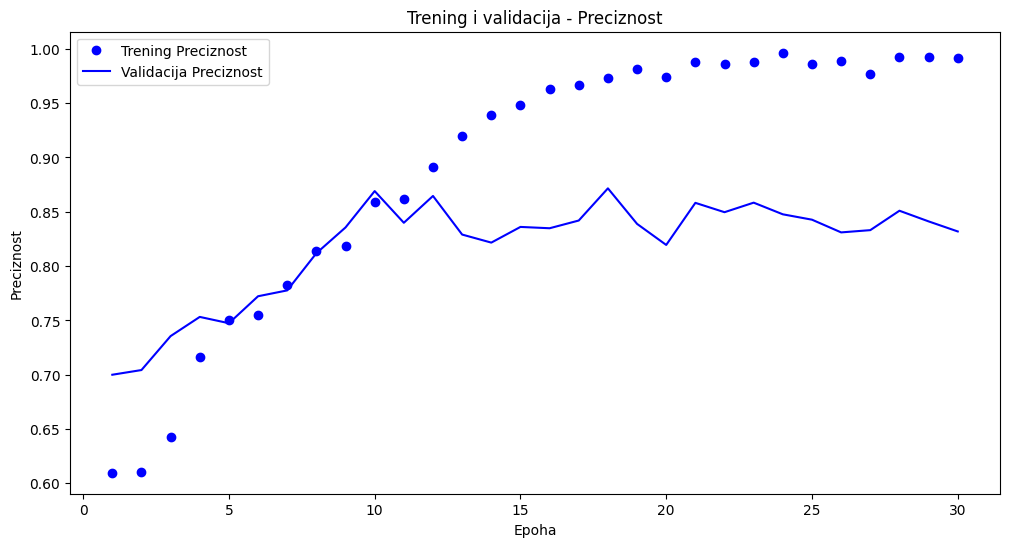

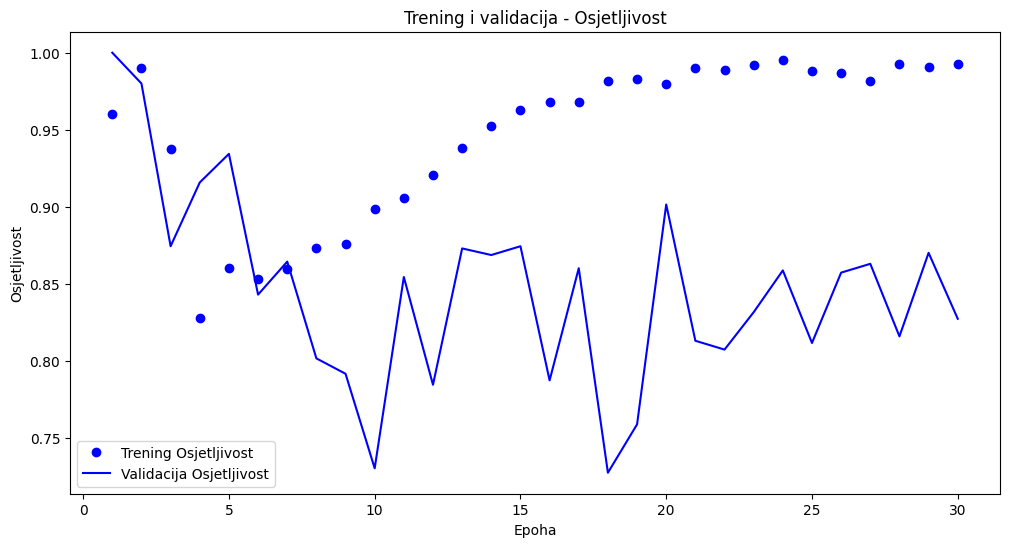

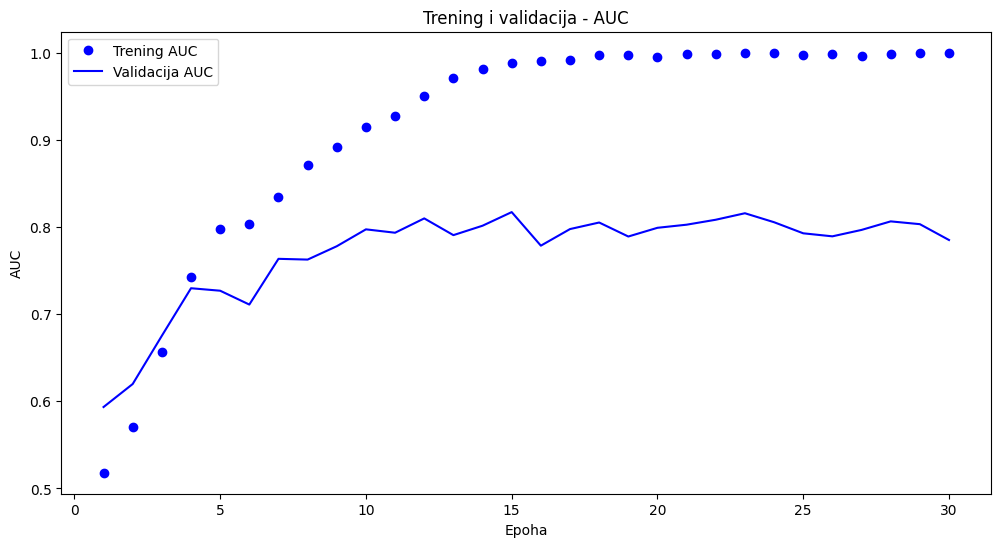

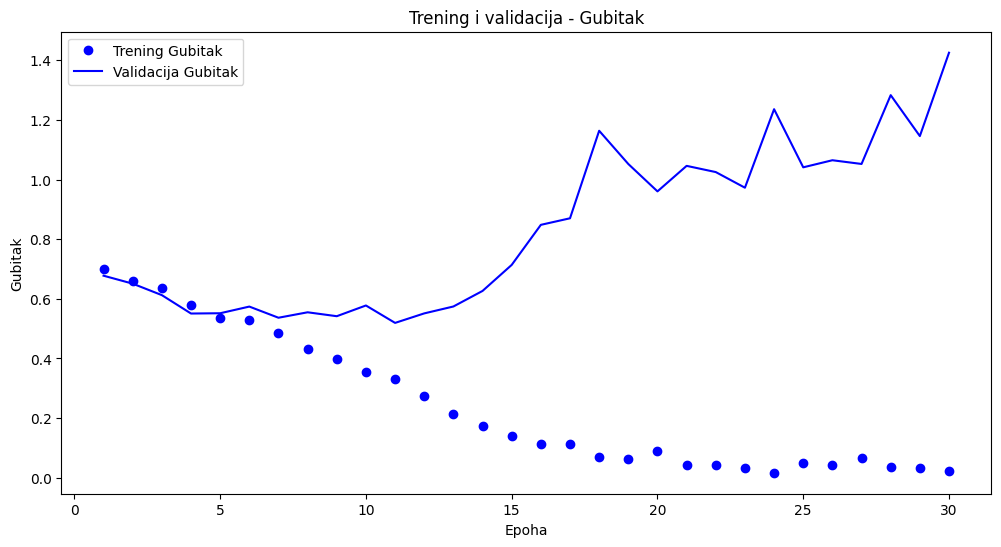

Rezultati metrika za model treniran nad 600 sintetičkih instanci:


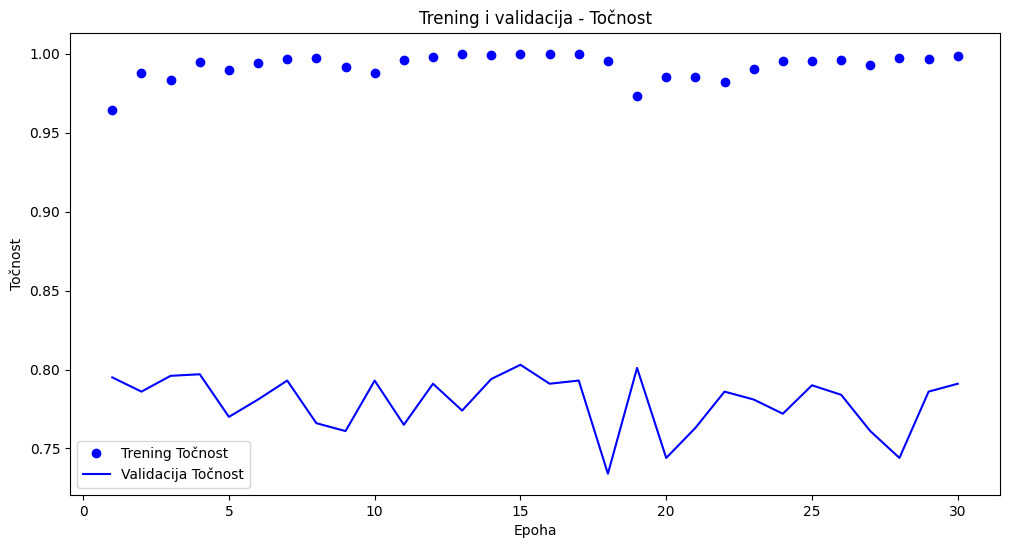

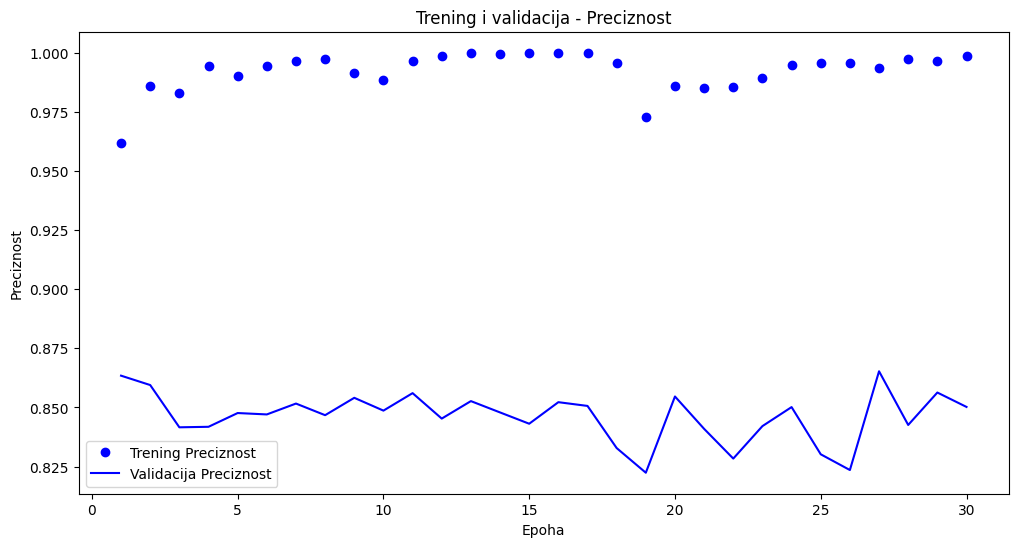

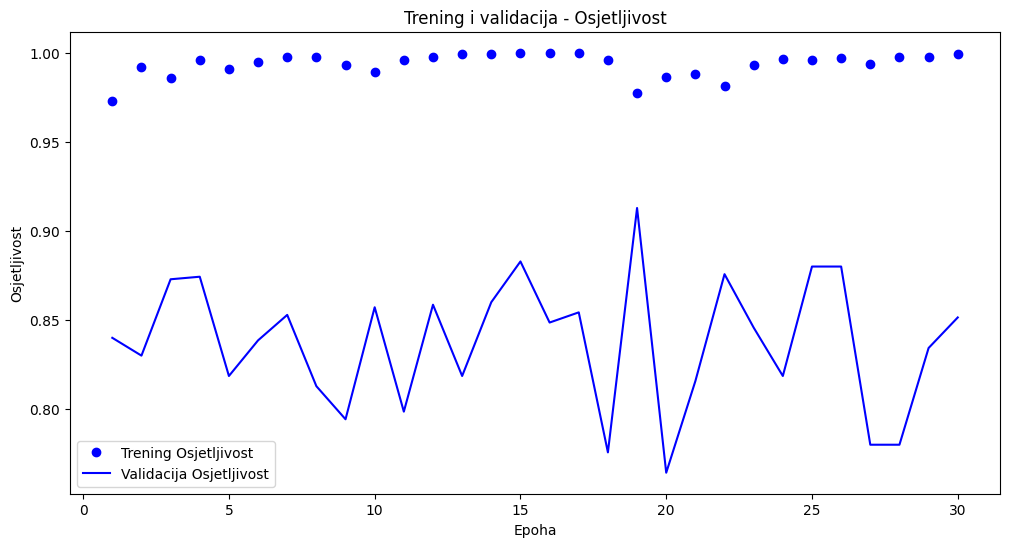

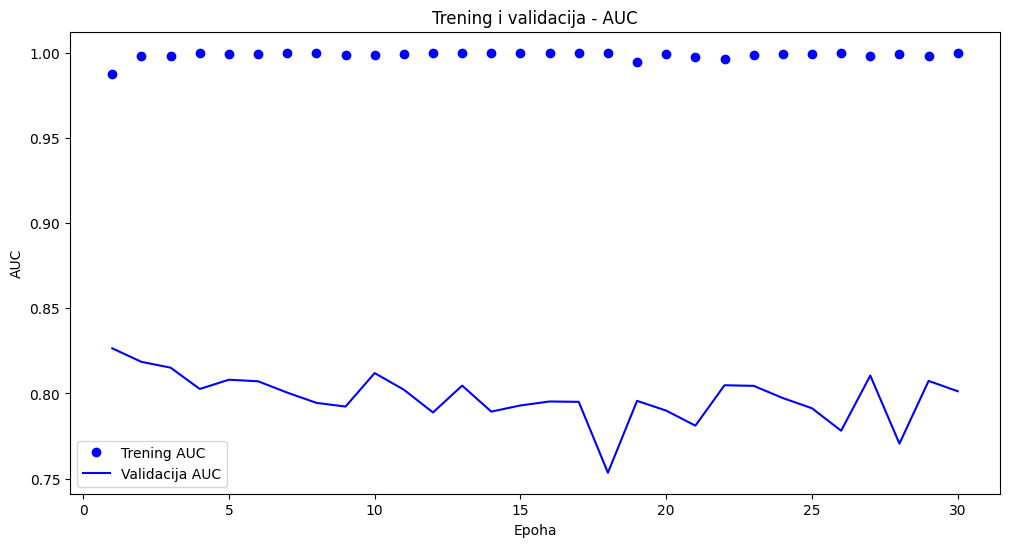

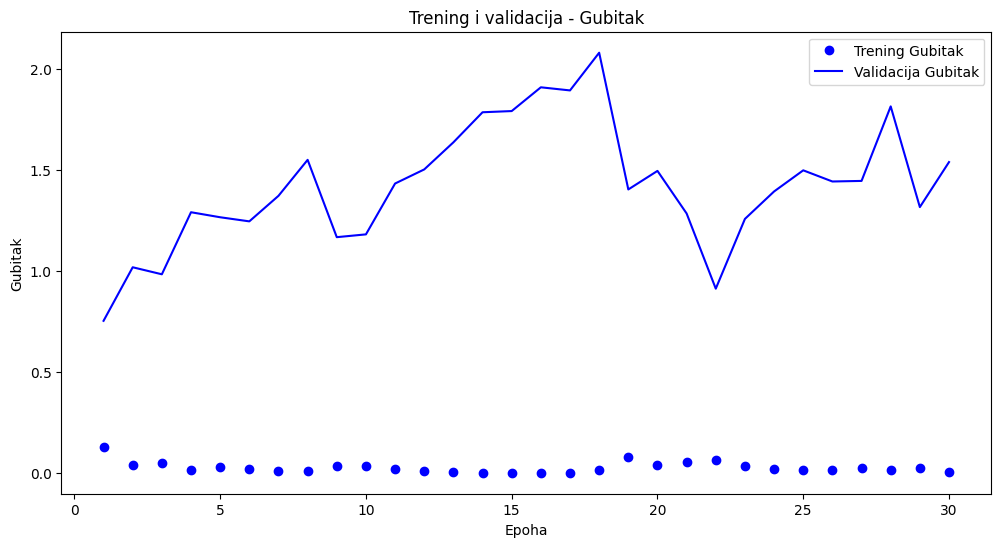

Rezultati metrika za model treniran nad 900 sintetičkih instanci:


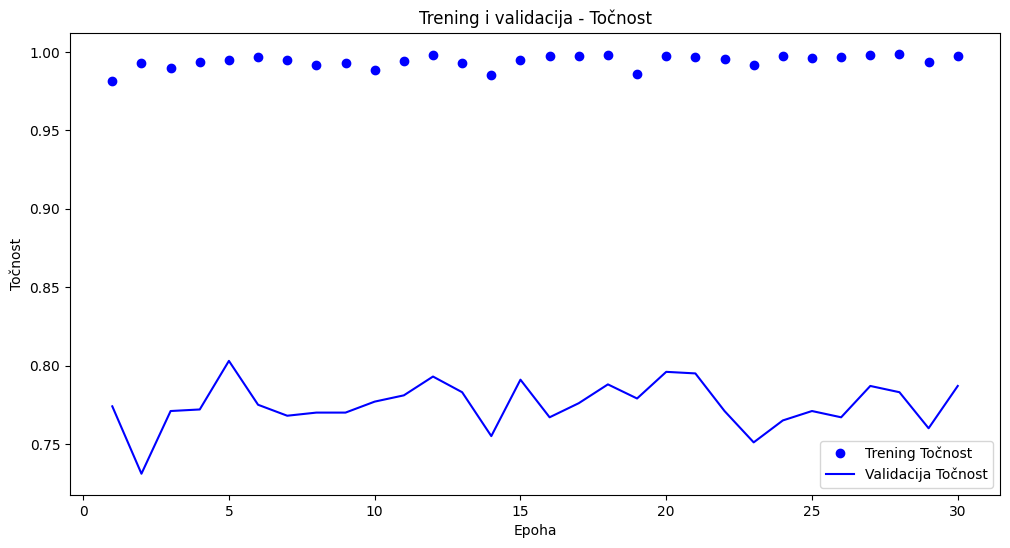

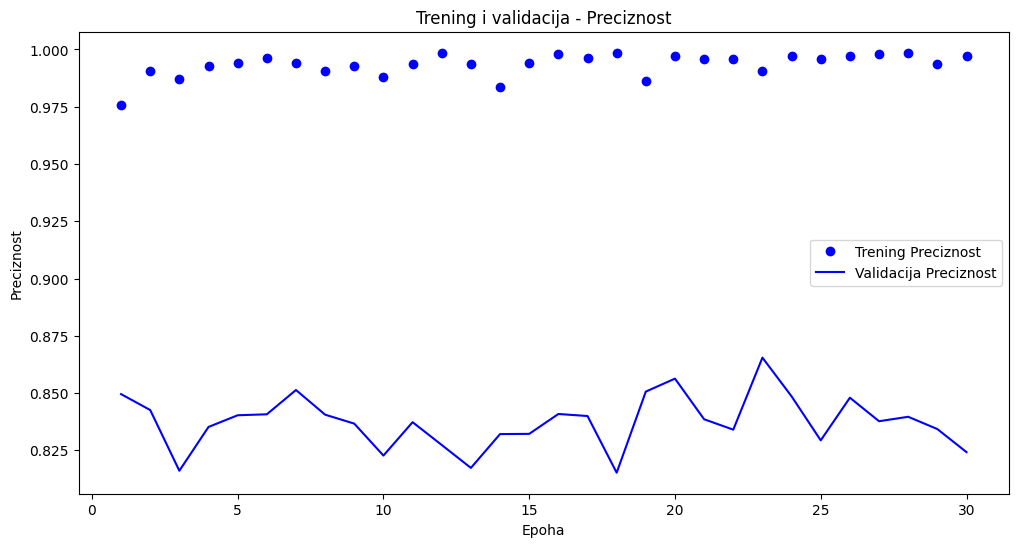

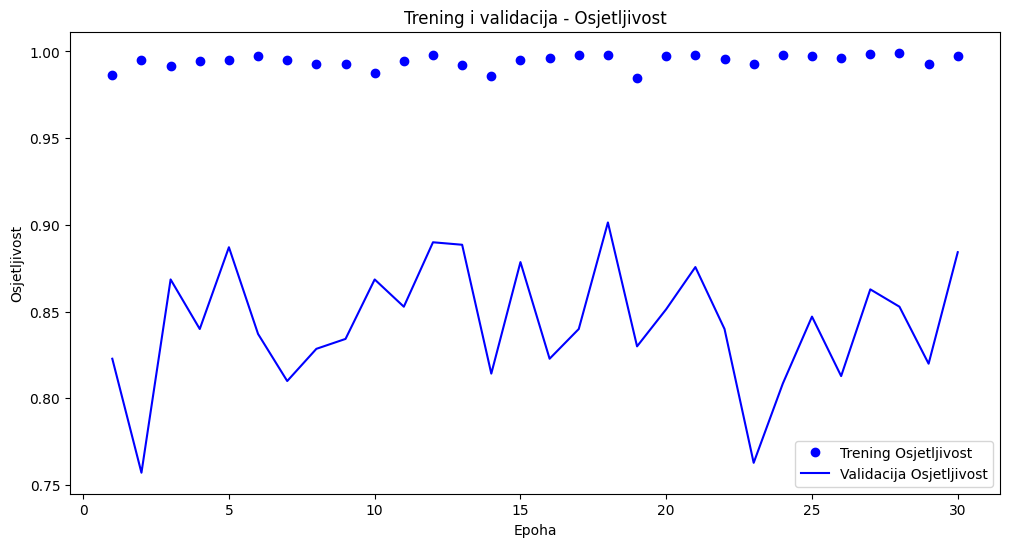

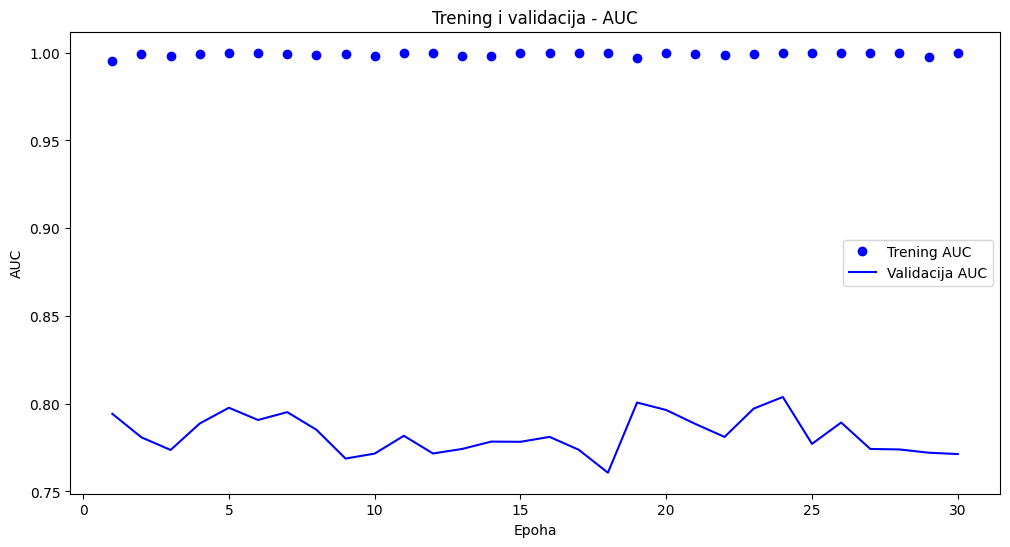

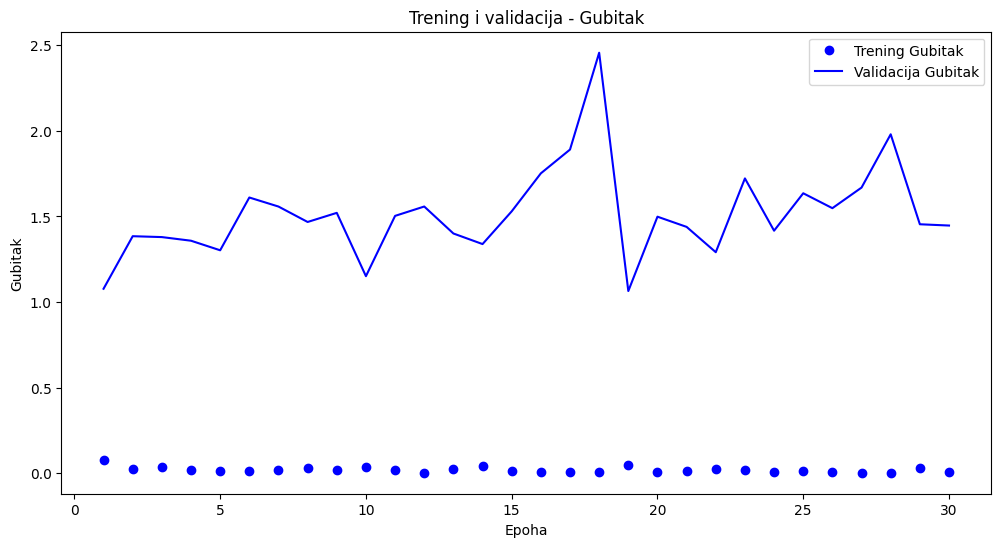

In [ ]:
# Prikaz svih praćenih metrika
for num_synthetic_images, history in all_histories.items():
    print(f"Rezultati metrika za model treniran nad {num_synthetic_images} sintetičkih instanci:")
    plot_all_metrics(history)


In [ ]:
from tensorflow.keras import metrics

# Učitavanje najboljeg modela (po gubitku)
test_model = keras.models.load_model("/content/drive/MyDrive/best_synthetic_data_model.keras")

# Evaluacija najboljeg modela nad testnim podatkovnim setom
test_metrics = test_model.evaluate(test_dataset)

# test_metrics u prvom elementu ima spremljen gubitak,
# ostali elementi su metrike redom pojavljivanja kao i kod kompajliranja modela
print(f"Test gubitak: {test_metrics[0]:.3f}")
print(f"Test točnost: {test_metrics[1]:.3f}")
print(f"Test preciznost: {test_metrics[2]:.3f}")
print(f"Test osjetljivost: {test_metrics[3]:.3f}")
print(f"Test AUC: {test_metrics[4]:.3f}")

63/63 [==============================] - 49s 616ms/step - loss: 1.2601 - accuracy: 0.7780 - precision: 0.8464 - recall: 0.8343 - auc: 0.8011
Test gubitak: 1.260
Test točnost: 0.778
Test preciznost: 0.846
Test osjetljivost: 0.834
Test AUC: 0.801


In [ ]:
# Ekstrakcija istinitih vrijednosti i predviđenih vjerojatnosti iz testnog seta
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = test_model.predict(test_dataset)

63/63 [==============================] - 1s 20ms/step


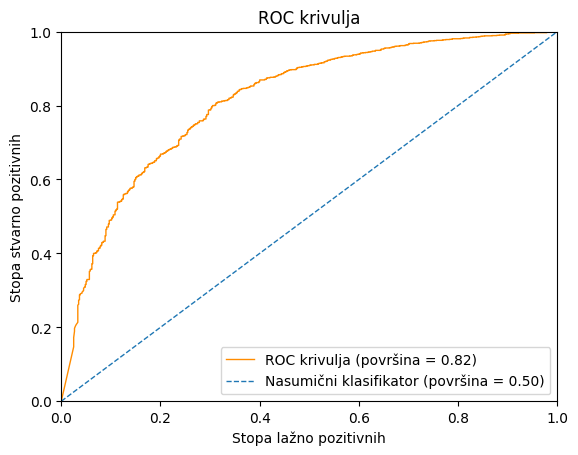

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC krivulja i AUC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Vrijednosti nasumičnog klasifikatora (50%)
fpr_random = [0, 1]
tpr_random = [0, 1]

# Crtanje ROC krivulje
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC krivulja (površina = %0.2f)' % roc_auc)
plt.plot(fpr_random, tpr_random, linestyle='--', lw=1, label='Nasumični klasifikator (površina = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Stopa lažno pozitivnih')
plt.ylabel('Stopa stvarno pozitivnih')
plt.title('ROC krivulja')
plt.legend(loc="lower right")
plt.show()

### Performanse modela nad manje zastupljenom klasom

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Konverzija predviđenih vjerojatnosti u dvije klase
y_pred_labels = (y_pred > 0.5).astype("int32")

# Detaljizirano klasifikacijsko izvješće
print(classification_report(y_true, y_pred_labels, target_names=['mačka', 'pas']))

# Metrike za klasu mačka.
precision = precision_score(y_true, y_pred_labels, pos_label=0)
recall = recall_score(y_true, y_pred_labels, pos_label=0)
f1 = f1_score(y_true, y_pred_labels, pos_label=0)

print(f'Preciznost za klasu mačka: {precision:.3f}')
print(f'Osjetljivost za klasu mačka: {recall:.3f}')
print(f'F1 metrika za klasu mačka: {f1:.3f}')


              precision    recall  f1-score   support

       mačka       0.63      0.65      0.64       600
         pas       0.85      0.83      0.84      1400

    accuracy                           0.78      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.78      0.78      0.78      2000

Preciznost za klasu mačka: 0.626
Osjetljivost za klasu mačka: 0.647
F1 metrika za klasu mačka: 0.636
